In [ ]:
import os
import contextlib
import glob
import random

import numpy as np
import pandas as pd

# Quieter TF logs + friendlier GPU memory behavior.
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "3")
os.environ.setdefault("TF_FORCE_GPU_ALLOW_GROWTH", "true")

@contextlib.contextmanager
def silence_stderr(enabled: bool = True):
    """Temporarily silence native stderr (useful for noisy TF/CUDA init logs)."""
    if not enabled:
        yield
        return
    fd = os.dup(2)
    try:
        with open(os.devnull, "w") as devnull:
            os.dup2(devnull.fileno(), 2)
            yield
    finally:
        os.dup2(fd, 2)
        os.close(fd)

SILENCE_TF_CPP_LOGS = True

with silence_stderr(SILENCE_TF_CPP_LOGS):
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Flatten, Dense
    from tensorflow.keras.applications.vgg16 import preprocess_input

    # Initialize GPU early so later cells are quieter.
    _ = tf.config.list_physical_devices("GPU")

tf.get_logger().setLevel("ERROR")

from PIL import Image
import matplotlib.image as img
import matplotlib.pyplot as plt


In [ ]:
DATASET_ROOT = "../input/human-action-recognition-har-dataset/Human Action Recognition"
TRAIN_DIR = os.path.join(DATASET_ROOT, "train")
TEST_DIR = os.path.join(DATASET_ROOT, "test")

train_csv = pd.read_csv(os.path.join(DATASET_ROOT, "Training_set.csv"))
test_csv = pd.read_csv(os.path.join(DATASET_ROOT, "Testing_set.csv"))


In [ ]:
train_fol = glob.glob(os.path.join(TRAIN_DIR, "*"))
test_fol = glob.glob(os.path.join(TEST_DIR, "*"))


In [ ]:
train_filenames = train_csv["filename"]
train_labels_series = train_csv["label"]


In [ ]:
train_image_paths = [os.path.join(TRAIN_DIR, fn) for fn in train_csv["filename"].tolist()]
train_labels = train_csv["label"].tolist()


In [ ]:
label_ids, class_names = pd.factorize(pd.Series(train_labels))
index_to_label = {int(i): name for i, name in enumerate(class_names)}
num_classes = len(class_names)

IMG_SIZE = (160, 160)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Stream images from disk (lower RAM) and prefetch for throughput.
def load_and_preprocess(path, label):
    img_bytes = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img_bytes, channels=3)
    img = tf.image.resize(img, IMG_SIZE, antialias=True)
    img = preprocess_input(tf.cast(img, tf.float32))
    return img, tf.cast(label, tf.int32)

train_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, label_ids))
train_ds = train_ds.shuffle(buffer_size=min(len(train_image_paths), 2048), seed=42, reshuffle_each_iteration=True)
train_ds = train_ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)


[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
vgg_model = Sequential()

pretrained_model = tf.keras.applications.VGG16(
    include_top=False,
    input_shape=(*IMG_SIZE, 3),
    pooling="avg",
    weights="imagenet",
)

for layer in pretrained_model.layers:
    layer.trainable = False

vgg_model.add(pretrained_model)
vgg_model.add(Flatten())
vgg_model.add(Dense(512, activation="relu"))
vgg_model.add(Dense(num_classes, activation="softmax"))


2022-06-23 05:45:10.339053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 05:45:10.343727: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 05:45:10.344457: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 05:45:10.345558: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [23]:
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 15)                7695      
Total params: 14,985,039
Trainable params: 270,351
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
with silence_stderr(SILENCE_TF_CPP_LOGS):
    history = vgg_model.fit(train_ds, epochs=20)


2022-06-23 05:45:14.074679: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 967680000 exceeds 10% of free system memory.
2022-06-23 05:45:15.081935: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 967680000 exceeds 10% of free system memory.
2022-06-23 05:45:15.782986: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60


2022-06-23 05:45:17.274746: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


394/394 [==============================] - 23s 36ms/step - loss: 2.1531 - accuracy: 0.4467
Epoch 2/60
394/394 [==============================] - 13s 33ms/step - loss: 1.2144 - accuracy: 0.6120
Epoch 3/60
394/394 [==============================] - 13s 33ms/step - loss: 0.9427 - accuracy: 0.6863
Epoch 4/60
394/394 [==============================] - 13s 33ms/step - loss: 0.7251 - accuracy: 0.7583
Epoch 5/60
394/394 [==============================] - 13s 33ms/step - loss: 0.5484 - accuracy: 0.8188
Epoch 6/60
394/394 [==============================] - 13s 33ms/step - loss: 0.4027 - accuracy: 0.8677
Epoch 7/60
394/394 [==============================] - 13s 33ms/step - loss: 0.2963 - accuracy: 0.9037
Epoch 8/60
394/394 [==============================] - 13s 33ms/step - loss: 0.2174 - accuracy: 0.9320
Epoch 9/60
394/394 [==============================] - 13s 33ms/step - loss: 0.1834 - accuracy: 0.9407
Epoch 10/60
394/394 [==============================] - 13s 33ms/step - loss: 0.1506 - accurac

In [ ]:
vgg_model.save_weights("model.weights.h5")

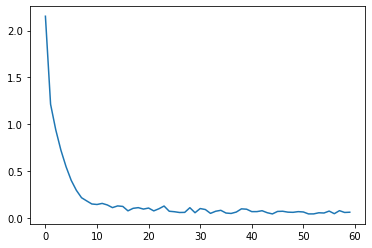

In [26]:
losss = history.history['loss']
plt.plot(losss)

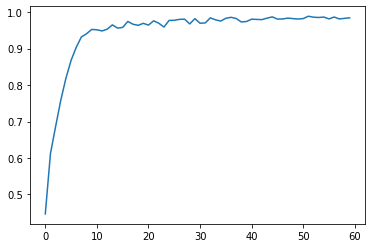

In [27]:
accu = history.history['accuracy']
plt.plot(accu)